In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score, roc_curve, auc)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import joblib

In [2]:
df = pd.read_csv("machine failure.csv")

In [3]:
df.shape

(10000, 14)

In [4]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


**dfset overview:**

**Sensor/Operational Inputs:**

- **A Unique Identifier (UID)** that ranges from 1 to 10000  
- **Product ID**, consisting of a letter **L** (for low), **M** (for medium), or **H** (for high), to indicate the product quality variant, and a variant-specific serial number.  
- **Air temperature**, in degrees Kelvin (K)  
- **Process Temperature**, in degrees Kelvin  
- **Rotational Speed**, in revolutions per minute (RPM)  
- **Torque**, in Newton-Meters (Nm)  
- **Tool wear**, in minutes. The quality variants **H**, **M**, and **L** add **5**, **3**, and **2** minutes of tool wear respectively to the tool used in the process  

**A Machine Failure Label**, to indicate whether the machine failed in the specific df point. This specific df point can have any of the following five independent failure modes:

- **Tool Wear Failure (TWF)**: the tool is replaced or fails at a randomly selected tool wear time, between 200 and 240 minutes  
- **Heat Dissipation Failure (HDF)**: heat dissipation causes a process failure if the difference between the air temperature and the process temperature is less than 8.6 K, and the tool's rotational speed is less than 1380 RPM  
- **Power Failure (PWF)**: the product of torque and rotational speed (in rad/s) equals the power required for the process. The process fails if this power falls below 3,500 W or exceeds 9,000 W  
- **OverStrain Failure (OSF)**: if the product of tool wear and torque exceeds 11,000 minimum Nm for the **L** product variant (12,000 for **M**, 13,000 for **H**), the process fails due to overstrain  
- **Random Failures (RNF)**: each process has a failure chance of 0.1%, regardless of the process parameters

In [5]:
df = df.rename(columns={'Product ID': 'Product_ID', 'Air temperature [K]': 'Air_temperature', 'Process temperature [K]': 'Process_temperature',
                            'Rotational speed [rpm]': 'Rotational_speed', 'Tool wear [min]': 'Tool_wear', 'Machine failure': 'Machine_failure',
                            'Torque [Nm]': 'Torque'})

In [6]:
df.UDI.nunique()
df.Product_ID.nunique()

10000

In [7]:
df = df.drop(['UDI','Product_ID'],axis=1)

In [8]:
df.head()

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [9]:
df.isnull().sum()

Type                   0
Air_temperature        0
Process_temperature    0
Rotational_speed       0
Torque                 0
Tool_wear              0
Machine_failure        0
TWF                    0
HDF                    0
PWF                    0
OSF                    0
RNF                    0
dtype: int64

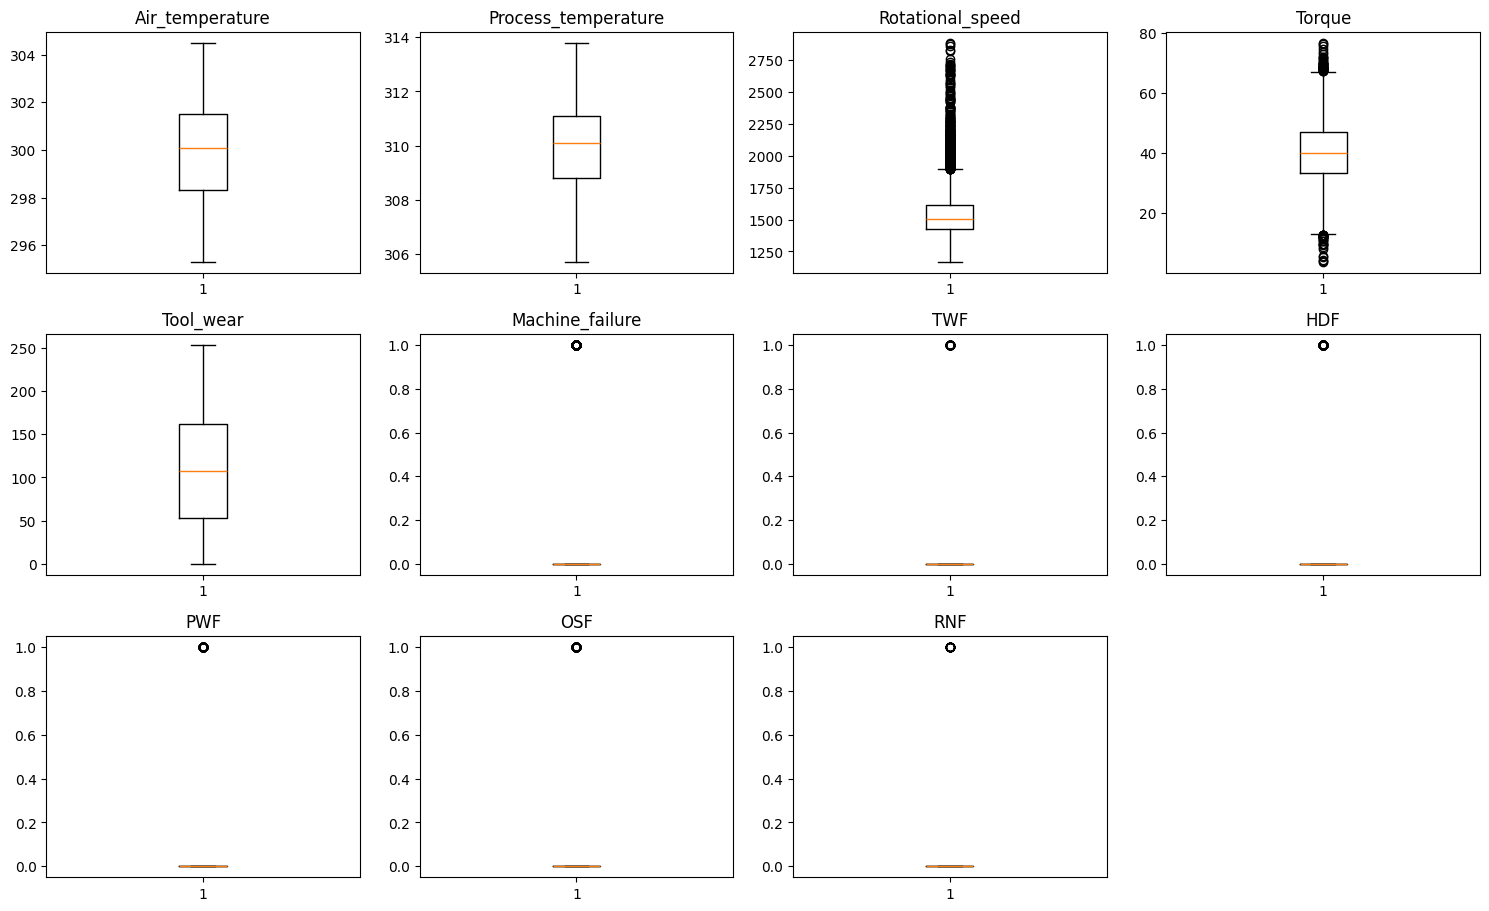

In [10]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

There are outliers present in the df set. However, no treatment will be applied as these are actual values observed.

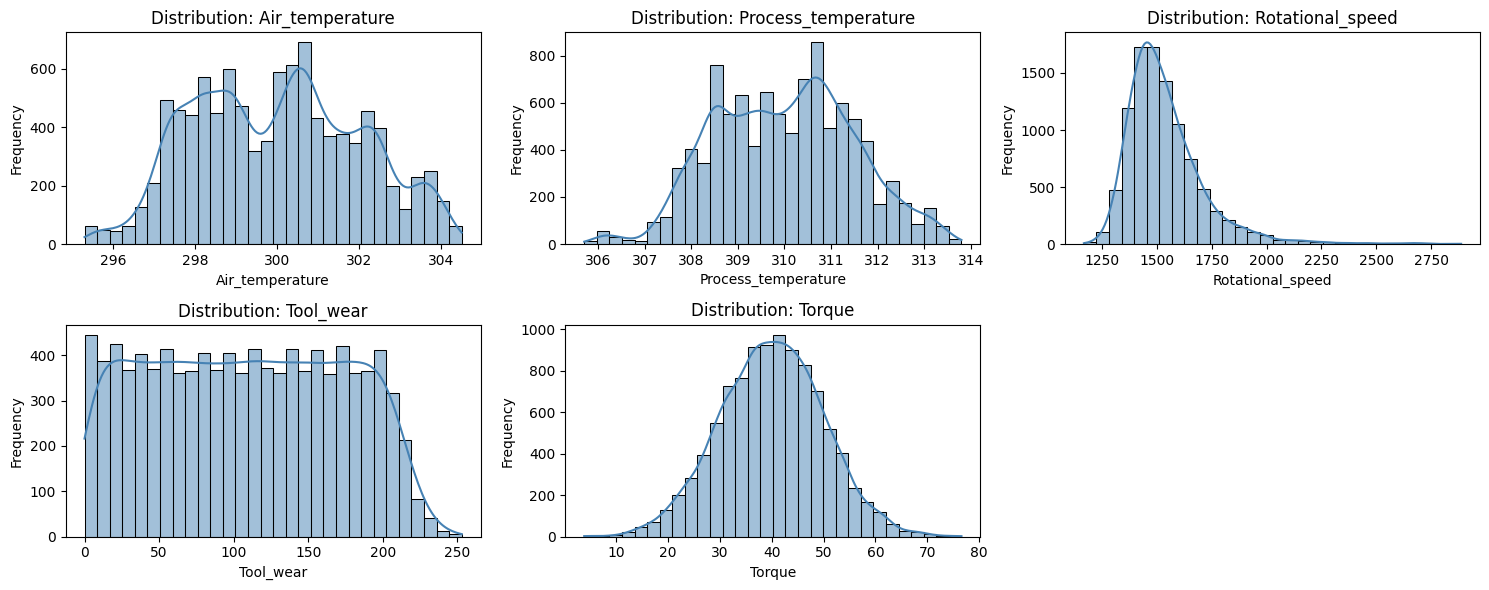

In [11]:
# Select sensor columns (excluding target/failure labels)
sensor_columns = df.select_dtypes(include='number').columns.difference(['Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF','Type'])

# Set layout
n_cols = 3
n_rows = int((len(sensor_columns) + n_cols - 1) / n_cols)
plt.figure(figsize=(n_cols * 5, n_rows * 3))

# Plot each sensor column as a histogram
for idx, col in enumerate(sensor_columns):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(df[col], kde=True, bins=30, color='steelblue')
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The rotational speed column is a right-skewed distribution rest are fairly normal distribution 

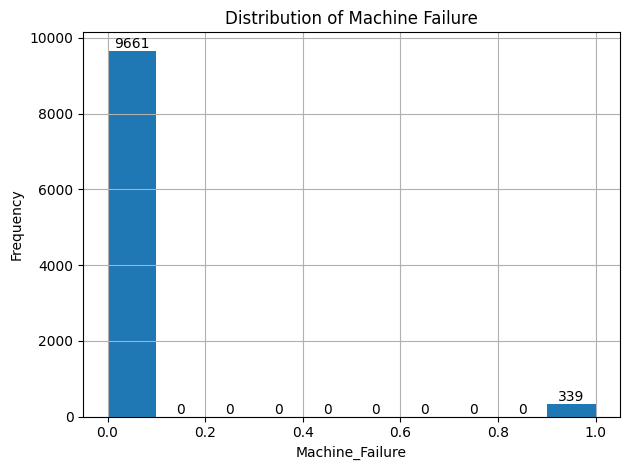

In [12]:
# Plot histogram
ax = df['Machine_failure'].hist()
plt.title('Distribution of Machine Failure')
plt.xlabel('Machine_Failure')
plt.ylabel('Frequency')

# Add count labels at the top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Count value
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Position at the top of the bar
                ha='center', va='center',  # Align text
                fontsize=10, color='black',  # Customize font
                xytext=(0, 5),  # Text offset
                textcoords='offset points')

plt.tight_layout()
plt.show()

Following is the failure count for each machine type

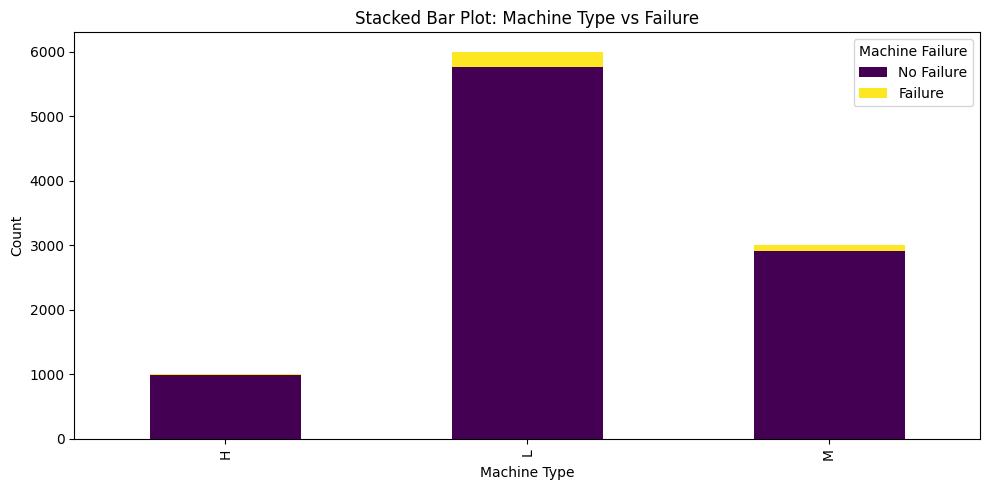

In [13]:
grouped = df.groupby(['Type', 'Machine_failure']).size().unstack(fill_value=0)

grouped.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='viridis')
plt.title('Stacked Bar Plot: Machine Type vs Failure')
plt.xlabel('Machine Type')
plt.ylabel('Count')
plt.legend(title='Machine Failure', labels=['No Failure', 'Failure'])
plt.tight_layout()
plt.show()

--- TWF ---   0: 9954   1: 46
--- HDF ---   0: 9885   1: 115
--- PWF ---   0: 9905   1: 95
--- OSF ---   0: 9902   1: 98
--- RNF ---   0: 9981   1: 19


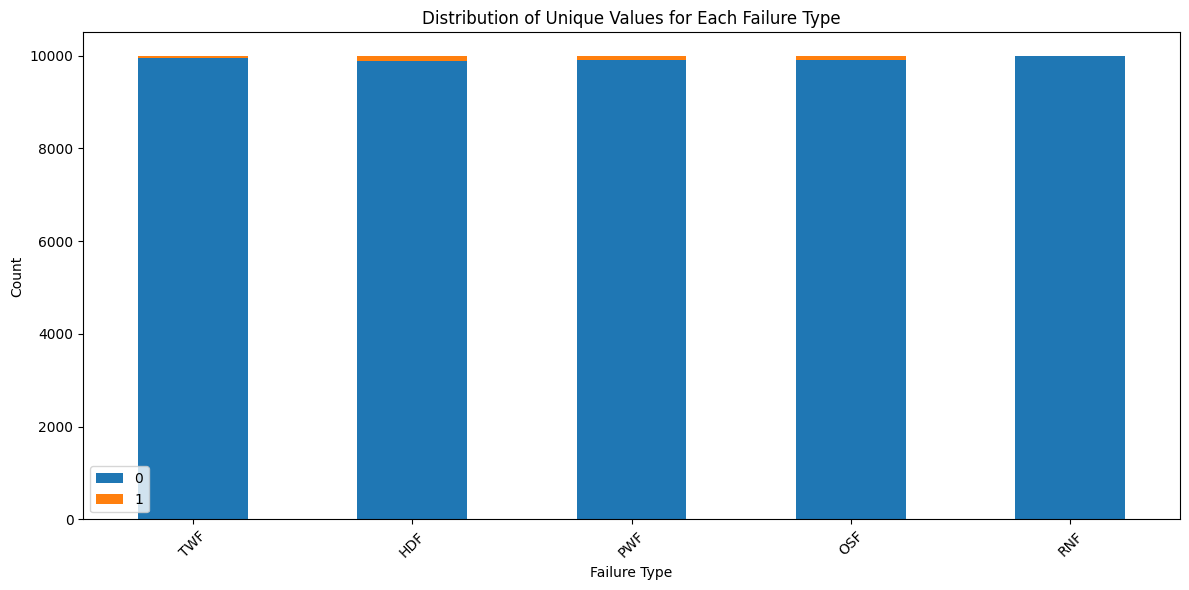

In [14]:
failure_columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

for col in failure_columns:
    counts = df[col].value_counts().to_dict()
    counts_str = '   '.join([f"{k}: {v}" for k, v in counts.items()])
    print(f"--- {col} ---   {counts_str}")


# Stacked bar plot for each failure type, showing the count of 0's and 1's
df[failure_columns].apply(lambda x: x.value_counts()).T.plot(kind='bar', stacked=True, figsize=(12, 6))

# Labeling the plot
plt.title('Distribution of Unique Values for Each Failure Type')
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The following are the types of failures that occured for the 339 machines that did fail.


--- Failure Type Distribution ---
TWF     46
HDF    115
PWF     95
OSF     98
RNF     19
dtype: int64


Text(0, 0.5, 'Count')

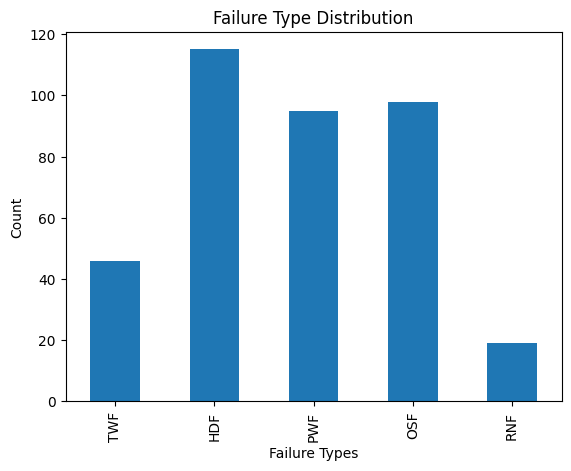

In [15]:
        # Failure Type Distribution
        failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
        print("\n--- Failure Type Distribution ---")
        failure_dist = df[failure_types].sum()
        print(failure_dist)

        failure_dist.plot(kind='bar')
        plt.title('Failure Type Distribution')
        plt.xlabel('Failure Types')
        plt.ylabel('Count')

       
       

Text(0.5, 1.0, 'Feature Correlation Heatmap')

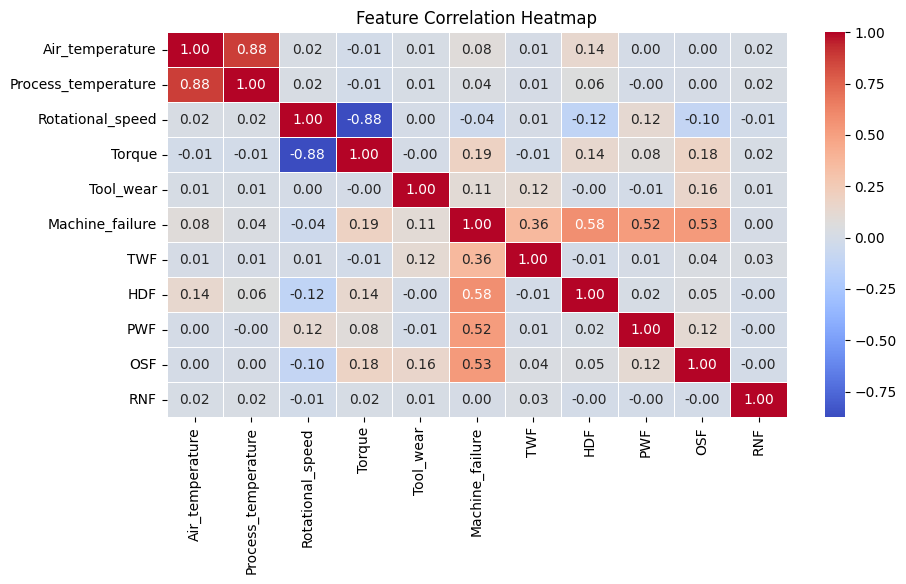

In [16]:
        plt.figure(figsize=(10, 5))
        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
        correlation_matrix = df[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
        plt.title('Feature Correlation Heatmap')


Observation:

We see high **direct** correlation between process temperature and air temperature.

We see high **indirect** correlation between torque and rotational speed.

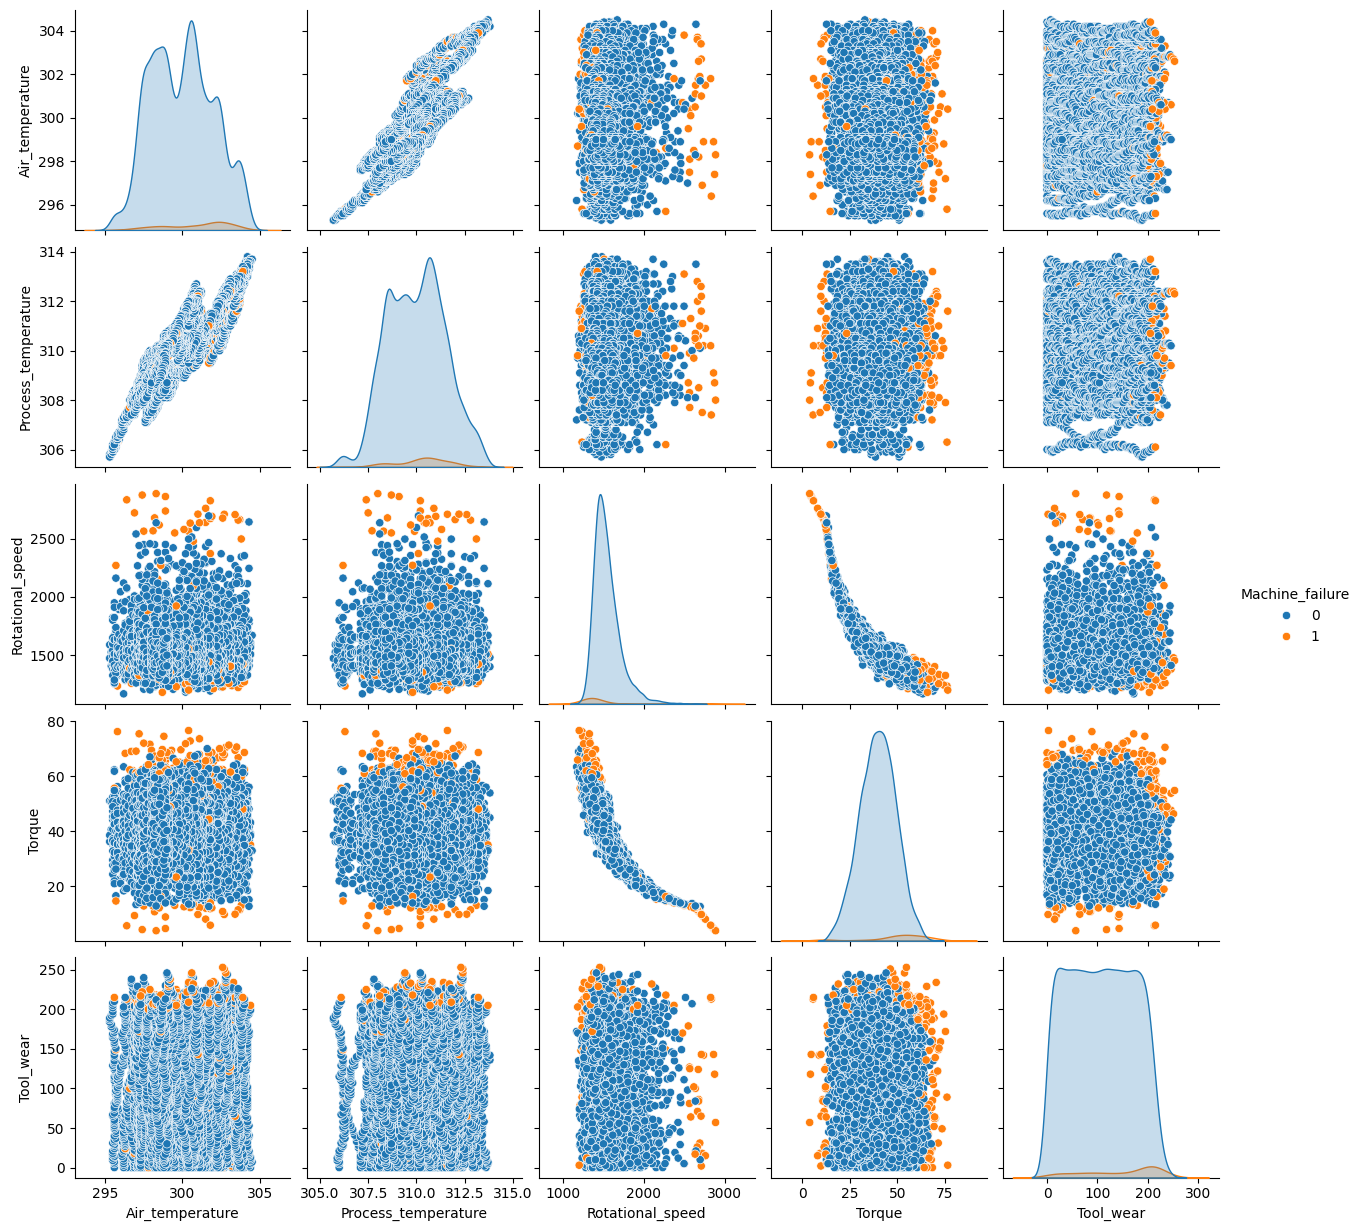

In [17]:
sns.pairplot(df.drop(['TWF','HDF','PWF','OSF','RNF'], axis=1),hue='Machine_failure')

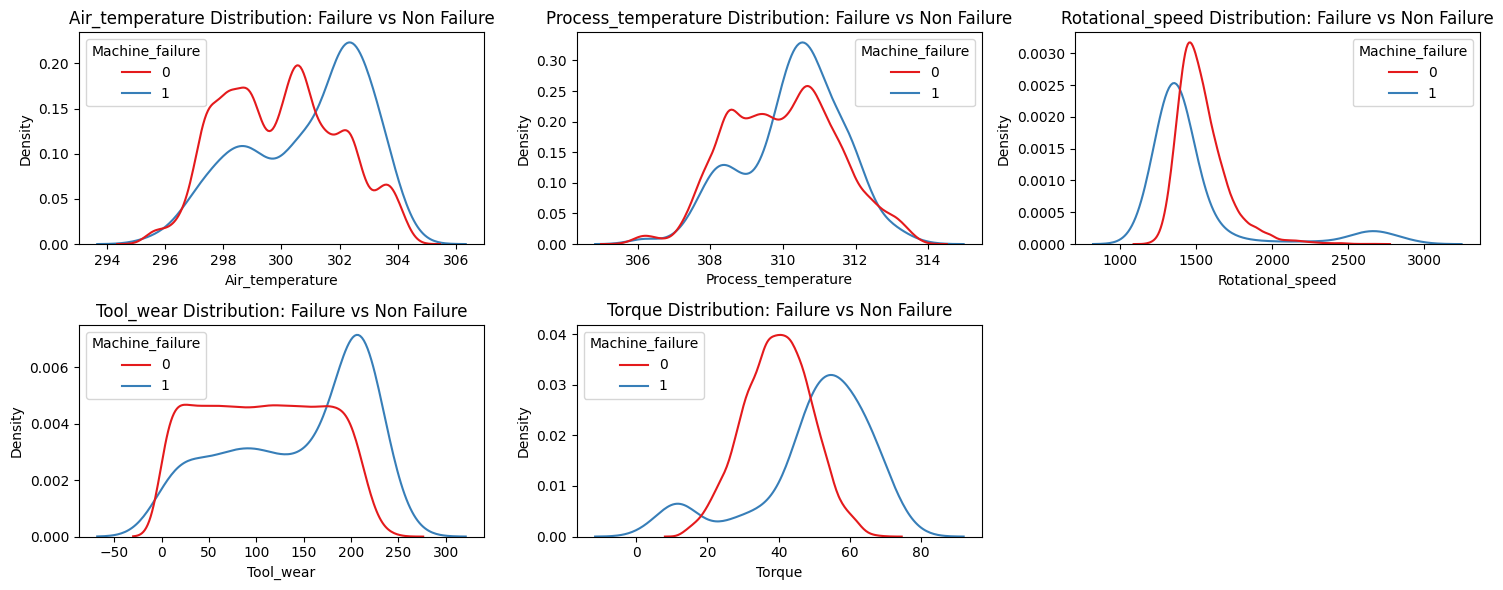

In [18]:
# Define your sensor columns (excluding failure-related columns)
sensor_columns = df.select_dtypes(include='number').columns.difference(['Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Type'])

# Set up the subplots
n_cols = 3  # number of plots per row
n_rows = int((len(sensor_columns) + n_cols - 1) / n_cols)  # calculate rows needed

plt.figure(figsize=(n_cols * 5, n_rows * 3))  # dynamically scale figure size

for idx, col in enumerate(sensor_columns):
    plt.subplot(n_rows, n_cols, idx + 1)
    try:
        sns.kdeplot(data=df, x=col, hue='Machine_failure', common_norm=False, palette='Set1')
        plt.title(f'{col} Distribution: Failure vs Non Failure')
        plt.xlabel(col)
        plt.ylabel('Density')
    except Exception as e:
        plt.title(f'Error plotting {col}')
        print(f"Error plotting {col}: {e}")

plt.tight_layout()
plt.show()

More machine failures occur at **higher** air temperatures, process temperatures, torque and tool wear.


More machine failures occur at **lower** rotational speeds.

In [19]:
import joblib

In [20]:
df = df.drop(columns=[col for col in failure_types if col in df.columns])

In [21]:
 categorical_columns = df.select_dtypes(include=['object']).columns
 le = LabelEncoder()
 for col in categorical_columns:
       df[col] = le.fit_transform(df[col].astype(str))

**Model Training and Evaluation**


--- Random Forest ---
Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1939
           1       0.86      0.41      0.56        61

    accuracy                           0.98      2000
   macro avg       0.92      0.70      0.77      2000
weighted avg       0.98      0.98      0.98      2000



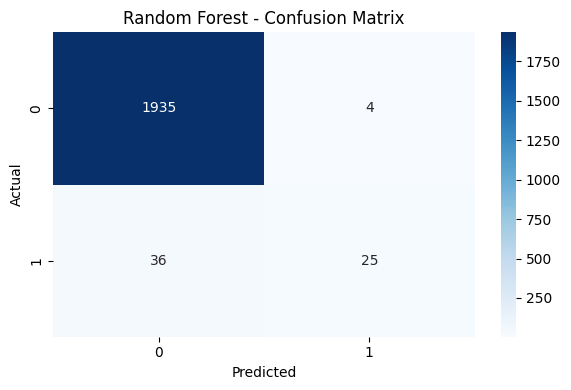

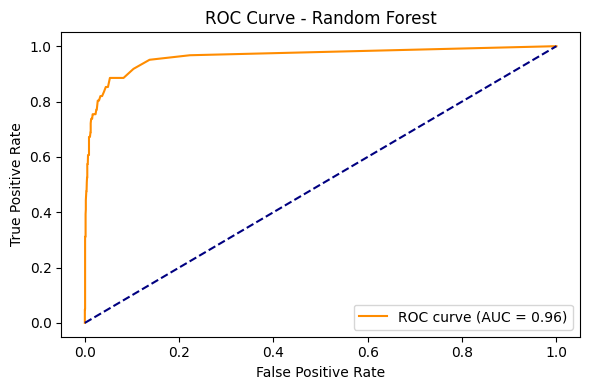


--- Logistic Regression ---
Accuracy: 0.8175
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1939
           1       0.13      0.85      0.22        61

    accuracy                           0.82      2000
   macro avg       0.56      0.83      0.56      2000
weighted avg       0.97      0.82      0.88      2000



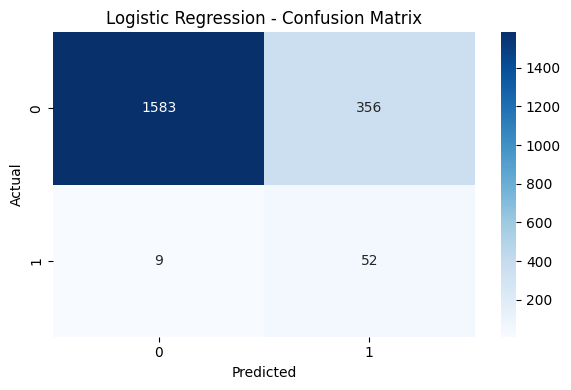

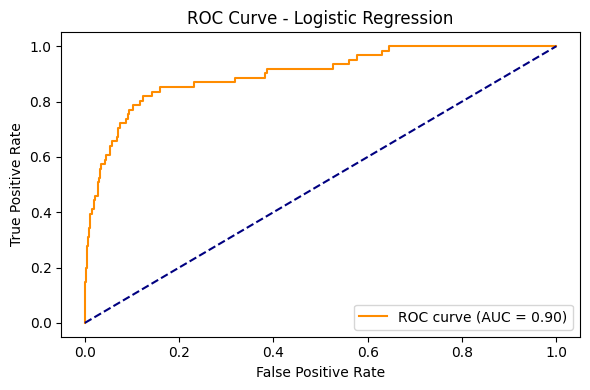


--- SVM (Linear) ---
Accuracy: 0.8265
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      1939
           1       0.13      0.85      0.23        61

    accuracy                           0.83      2000
   macro avg       0.56      0.84      0.57      2000
weighted avg       0.97      0.83      0.88      2000



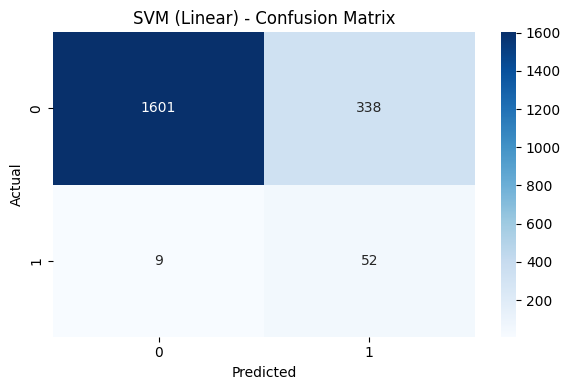

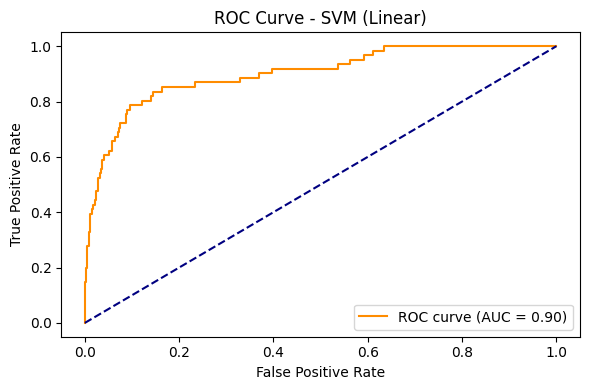

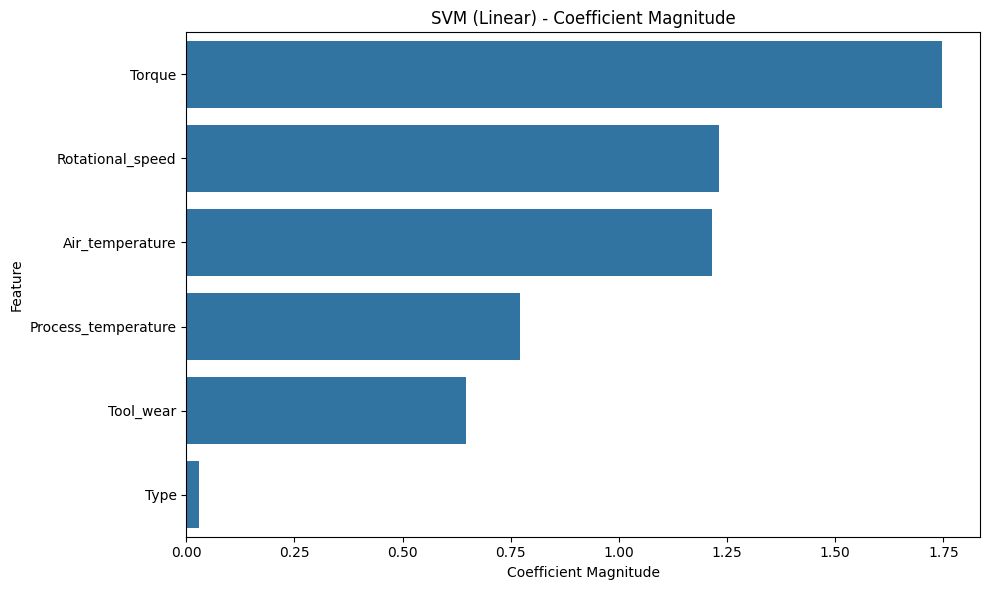


Top 5 Features - SVM (Linear):
               Feature  Coefficient Magnitude
4               Torque               1.747380
3     Rotational_speed               1.231630
1      Air_temperature               1.214247
2  Process_temperature               0.772068
5            Tool_wear               0.646804


In [22]:
# === Define features and target ===
X = df.drop(columns=['Machine_failure'])  # drop Product_ID
y = df['Machine_failure']

# === Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# === Define classifiers ===
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'SVM (Linear)': SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
}

# === Train, Evaluate, and Plot ===
for name, clf in classifiers.items():
    print(f"\n--- {name} ---")

    # Train model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    
    clf.fit(X_train, y_train)
    ...
    if name == 'Random Forest':
        joblib.dump(clf, 'model.pkl')
        
        
    joblib.dump(X.columns.tolist(), 'feature_order.pkl')


    # Accuracy & Classification Report
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
    plt.title(f'ROC Curve - {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # === Feature Importance / Coefficients ===
if name == 'Random Forest':
    importances = clf.feature_importances_
    feature_label = 'Importance'
elif name in ['Logistic Regression', 'SVM (Linear)']:
    importances = abs(clf.coef_[0])  # Take absolute values for ranking
    feature_label = 'Coefficient Magnitude'
else:
    importances = None

if importances is not None:
    feature_names = X.columns
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        feature_label: importances
    }).sort_values(feature_label, ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_label, y='Feature', data=feature_imp_df)  # Corrected here
    plt.title(f'{name} - {feature_label}')
    plt.tight_layout()
    plt.show()

    print(f"\nTop 5 Features - {name}:")
    print(feature_imp_df.head())


**Cross Validation**

Of the 3 models the Random Forest performs the best.

In [23]:

# === Cross-validation configuration ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === Perform Cross-Validation for Each Classifier ===
for name, clf in classifiers.items():
    print(f"\n--- {name} ---")
    
    # Accuracy from cross-validation
    scores = cross_val_score(clf, X_scaled, y, cv=cv, scoring='accuracy')
    print(f"Cross-Validation Accuracy Scores: {scores}")
    print(f"Mean Accuracy: {scores.mean():.4f} | Std Dev: {scores.std():.4f}")



--- Random Forest ---
Cross-Validation Accuracy Scores: [0.9835 0.9825 0.9795 0.981  0.9815]
Mean Accuracy: 0.9816 | Std Dev: 0.0014

--- Logistic Regression ---
Cross-Validation Accuracy Scores: [0.817  0.8215 0.8055 0.8205 0.834 ]
Mean Accuracy: 0.8197 | Std Dev: 0.0091

--- SVM (Linear) ---
Cross-Validation Accuracy Scores: [0.822  0.836  0.807  0.8295 0.8325]
Mean Accuracy: 0.8254 | Std Dev: 0.0103


**Sample Testing**

In [24]:

# Load trained model and scaler
model = joblib.load('model.pkl')


# Use the original features used during training
expected_features = ['Air_temperature', 'Process_temperature',
                     'Rotational_speed', 'Torque', 
                     'Tool_wear', 'Type']  # Add or remove based on actual X.columns

# Create test input
test_input = pd.DataFrame([{
    'Air_temperature': 298.9,
    'Process_temperature': 309.1,
    'Rotational_speed': 2870 ,
    'Torque': 4.6,
    'Tool_wear': 143,
    'Type': 1
}])

# Ensure column order and completeness
feature_order = joblib.load('feature_order.pkl')
test_input = test_input.reindex(columns=feature_order)

# Scale input
test_input_scaled = scaler.transform(test_input)

# Predict
prediction = model.predict(test_input_scaled)

# Show result
print("Prediction:", prediction)
prob = model.predict_proba(test_input_scaled)
print("Failure Probability:", prob[0][1])  # Probability of failure (class 1)


Prediction: [1]
Failure Probability: 0.92
